## Train a U-Net for cell segmentation

lorem ipsum

### 1. Train a U-Net with torch-em

In [ ]:
import os
from glob import glob

import torch
import torch_em
from torch_em.model import UNet2d

In [ ]:
# data loader
def get_data_loader(root_folder, batch_size):
    file_paths = glob(os.path.join(root_folder, "*.h5"))
    file_paths.sort()
    patch_shape = (512, 512)
    label_transform = torch_em.transform.label.BoundaryTransform(add_binary_target=True)
    loader = torch_em.default_segmentation_loader(
        raw_paths=file_paths, raw_key="raw/serum_IgG/s0",
        label_paths=file_paths, label_key="labels/cells/s0",
        patch_shape=patch_shape, ndim=2, batch_size=batch_size, 
        label_transform=label_transform,
    )
    return loader

In [ ]:
batch_size = 1
train_loader = get_data_loader("../data/train", batch_size=batch_size)
val_loader = get_data_loader("../data/val", batch_size=batch_size)

In [ ]:
from torch_em.util.debug import check_loader
check_loader(train_loader, n_samples=1)

In [ ]:
model = UNet2d(
    in_channels=1, out_channels=2, initial_features=32, final_activation="Sigmoid"
)

In [ ]:
dice_score = torch_em.loss.DiceLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer = torch_em.default_segmentation_trainer(
    name="boundary-segmentation-model",
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss=dice_score,
    metric=dice_score,
    learning_rate=1e-4,
    device=device,
)

In [ ]:
trainer.fit(iterations=10000)

Checking the training via tensorboard:
- `tensorboard --logdir=logs`

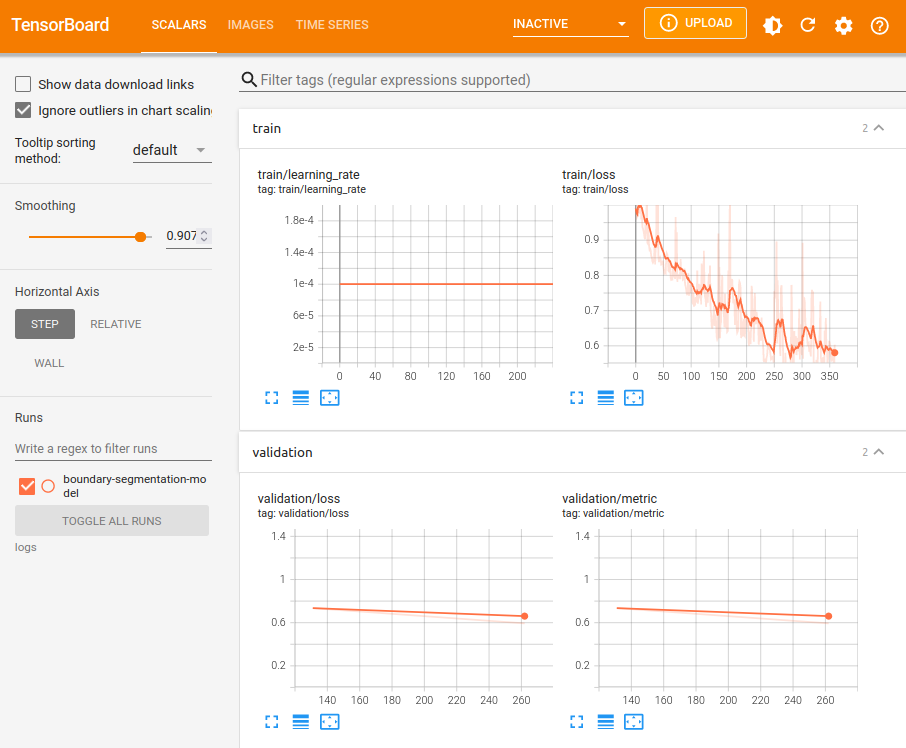
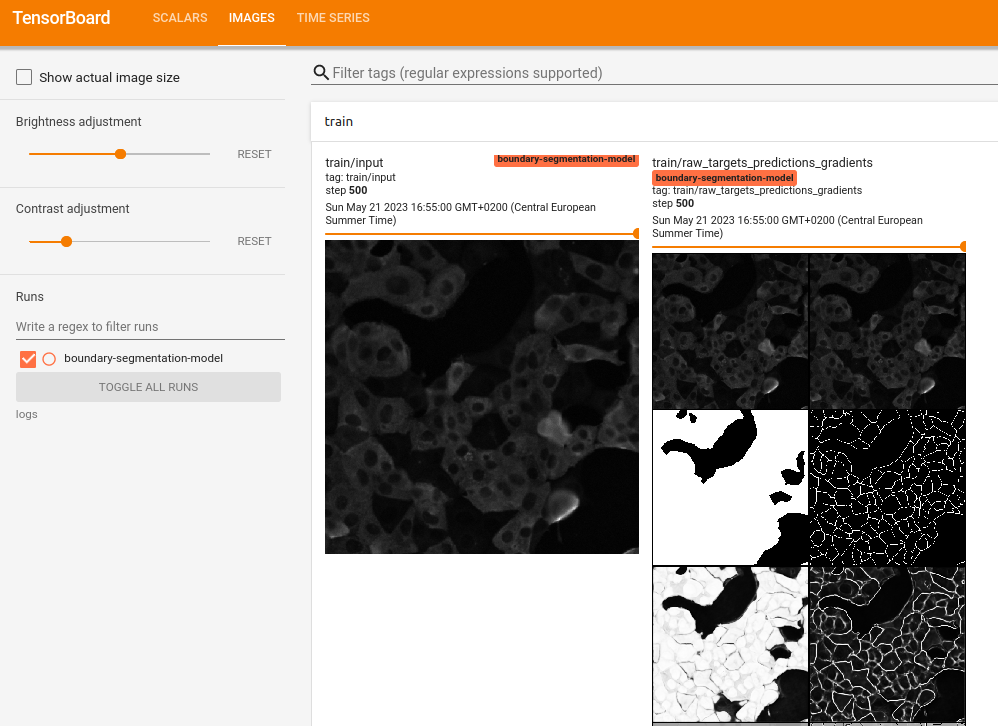

### 2. Export trained model to bioimage.io format

In [ ]:
import h5py
from torch_em.util.modelzoo import export_bioimageio_model

In [ ]:
model_root = "../data/trained_models"
model_folder = os.path.join(model_root, "boundary-segmentation")
os.makedirs(model_folder, exist_ok=True)

In [ ]:
image_path = "../data/train/gt_image_000.h5"
with h5py.File(image_path, "r") as f:
    input_ = f["raw/serum_IgG/s0"][:512, :512]

In [ ]:
doc = """#U-Net for Cell Membraine Segmentation in IF

A model for segmenting cell membranes and cell foreground in immunofluorescence images.
"""

citations = [{"text": "Pape et al.", "doi": "https://doi.org/10.1002/bies.202000257"}]

In [ ]:
export_bioimageio_model(
    checkpoint="checkpoints/boundary-segmentation-model",
    export_folder=model_folder,
    input_data=input_,
    name="boundary_segmentation_model",
    authors=[{"name": "Your Name", "affiliation": "Your Affiliation"}],
    tags=["uner", "cells", "2d", "immunofluorescence"],
    license="CC-BY-4.0",
    documentation=doc,
    description="Segment cell membranes in IF images",
    cite=citations,
    input_optional_parameters=False,
    maintainers=[{"github_user": "Your Github Handle"}]  # alternatively you can also give your mail address
)

`../data/trained_models/boundary-segmentation/boundary_segmentation_model.zip`

### 3. Exercises

**What's next**